# Prerequisites

## Importing Required Libraries

In [1]:
import os

import numpy as np
import pandas as pd
from scipy.sparse import issparse

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

from sklearn.metrics import silhouette_score

import pickle

### Loading Data

In [2]:
os.chdir('..')
os.chdir('data')
raw_dataframe= pd.read_csv('amz_us_price_prediction_dataset.csv')
os.chdir('..')
os.chdir('notebook')

# Problem Statement

**The objective is to create a prediction model that will assist sellers in pricing their products within the optimal price range to generate the most sales.**

# Data Handling

## NaN value handling

In [3]:
print(raw_dataframe.isna().sum()*100/len(raw_dataframe))

uid                  0.000000
asin                 0.000000
title                0.000058
stars                0.000000
reviews              0.000000
price                0.000000
category             0.000000
isBestSeller         0.000000
boughtInLastMonth    0.000000
dtype: float64


The dataset is mostly free from NaN values.

## Duplicated value handling

In [4]:
raw_dataframe.duplicated().sum()

0

The dataset is free from duplicated rows.

## Dropping extraneous columns

In [5]:
raw_dataframe.head()

,uid,asin,title,stars,reviews,price,category,isBestSeller,boughtInLastMonth
0,1,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",4.5,0,139.99,Suitcases,False,2000
1,2,B07GDLCQXV,Luggage Sets Expandable PC+ABS Durable Suitcas...,4.5,0,169.99,Suitcases,False,1000
2,3,B07XSCCZYG,Platinum Elite Softside Expandable Checked Lug...,4.6,0,365.49,Suitcases,False,300
3,4,B08MVFKGJM,Freeform Hardside Expandable with Double Spinn...,4.6,0,291.59,Suitcases,False,400
4,5,B01DJLKZBA,Winfield 2 Hardside Expandable Luggage with Sp...,4.5,0,174.99,Suitcases,False,400


In [6]:
raw_dataframe.nunique()/len(raw_dataframe)

uid                  1.000000
asin                 0.821900
title                0.813702
stars                0.000024
reviews              0.007417
price                0.017529
category             0.000136
isBestSeller         0.000001
boughtInLastMonth    0.000017
dtype: float64

In [7]:
selected_columns= ['stars', 'reviews', 'price', 'category', 'isBestSeller', 'boughtInLastMonth']

In [8]:
dataframe= raw_dataframe[selected_columns]

# Data Manipulation

## Feature Engineering

As provided in the knowledge base of problem set, only 1-2 % of buyers leave a review for the product.

So, let us take 1.5% as the median of the value.

total review count = 1.5% x total sale count

total sale count = 100 x 2/3 x total review count

**total sale count = 66.67 x total review count**

In [9]:
dataframe.loc[:, 'estimatedSaleCount']= round(66.67 * dataframe['reviews'])

C:\Users\Akash\AppData\Local\Temp\ipykernel_7112\2103240321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, 'estimatedSaleCount']= round(66.67 * dataframe['reviews'])


**estimated revenue = price x total sale count**

In [10]:
dataframe.loc[:, 'estimatedRevenue']= dataframe.price*dataframe.estimatedSaleCount

C:\Users\Akash\AppData\Local\Temp\ipykernel_7112\678245605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, 'estimatedRevenue']= dataframe.price*dataframe.estimatedSaleCount


In [11]:
dataframe= dataframe.drop('estimatedSaleCount', axis= 1)

### Encoding dataframe

Using label encoder on categorical columns.

In [12]:
dataframe.isBestSeller= dataframe.isBestSeller.astype(int)

In [13]:
encoder= LabelEncoder()

dataframe.category= encoder.fit_transform(dataframe.category)

### Performing clustering

In [14]:
sample_dataframe= dataframe.sample(10_000, random_state= 42)

Finding WCSS (Within-Cluster Sum of Squares)

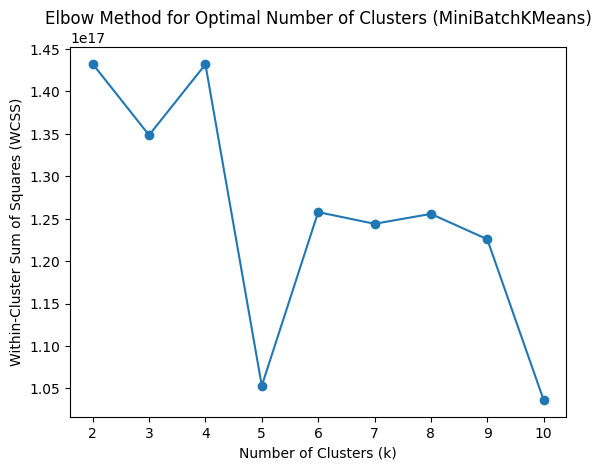

In [15]:
WCSS= []
for k in range(2, 11):
    KMeans= MiniBatchKMeans(k, random_state= 42)
    KMeans.fit(sample_dataframe)
    WCSS.append(KMeans.inertia_)

plt.plot(range(2, 11), WCSS, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters (MiniBatchKMeans)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)');

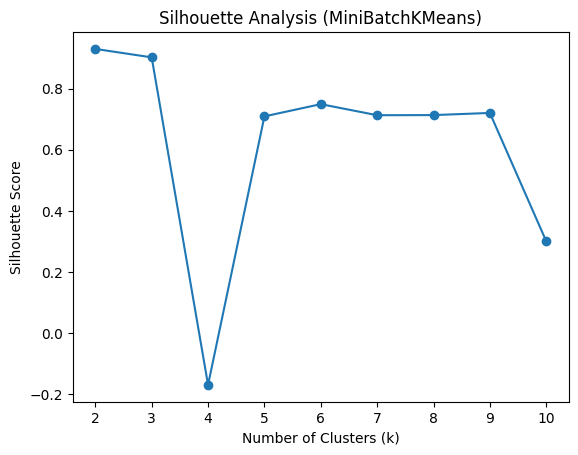

In [16]:
SIL= []
for k in range(2, 11):
    KMeans= MiniBatchKMeans(k, random_state= 42)
    KMeans.fit(sample_dataframe)
    SIL.append(silhouette_score(sample_dataframe, KMeans.labels_))

plt.plot(range(2, 11), SIL, marker='o')
plt.title('Silhouette Analysis (MiniBatchKMeans)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score');

There is no clear separation of data into distinct clusters.

### Adding price optimality category feature

Adding a categorizer which tells how optimally a product is priced.

In [17]:
bin_edges = [0, 10, 100, 1000, 10_000, 100_000, float('inf')]
bin_labels = [0, 1, 2, 3, 4, 5]

dataframe['priceOptimality'] = pd.cut(dataframe.reviews, bins= bin_edges, labels= bin_labels, right=False)

## Check sparsity of data

In [18]:
flag= issparse(dataframe)

if flag:
    print("The data is sparse.")
else:
    print("The data is not sparse.")

The data is not sparse.


# Data Visualization

Updating sample dataframe.

In [19]:
sample_dataframe= dataframe.sample(25_000, random_state= 42)

## Linear correlation

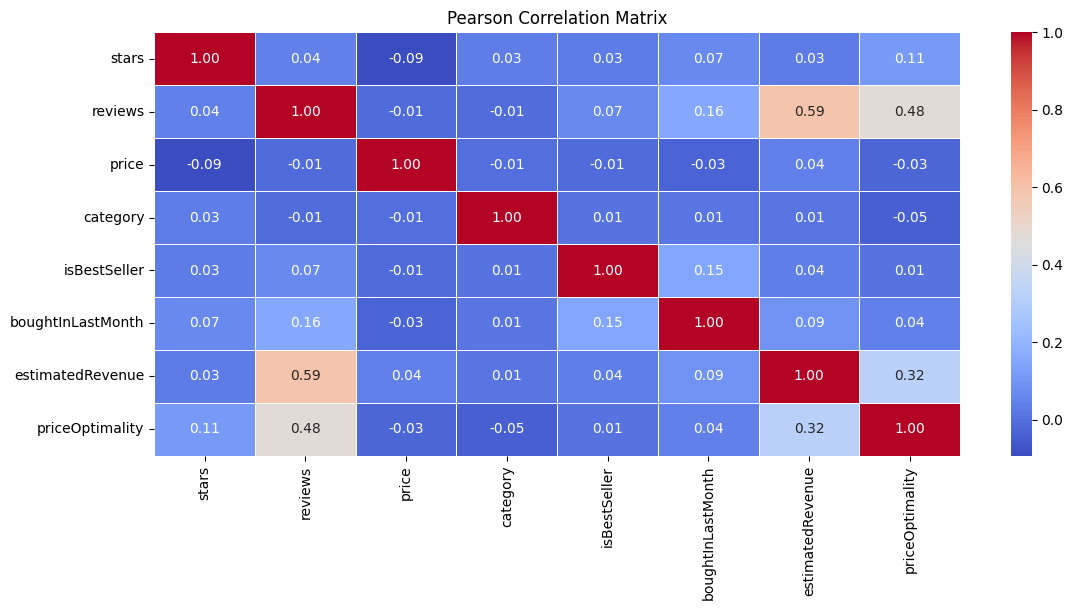

In [20]:
plt.figure(figsize= (13, 5.5))
sns.heatmap(sample_dataframe.corr(),
            annot= True,
            cmap= 'coolwarm',
            fmt= '.2f',
            linewidths= 0.5)
plt.title('Pearson Correlation Matrix');

## Non-linear correlation

In [21]:
sample_features= sample_dataframe.drop('price', axis= 1)
sample_target= sample_dataframe.price

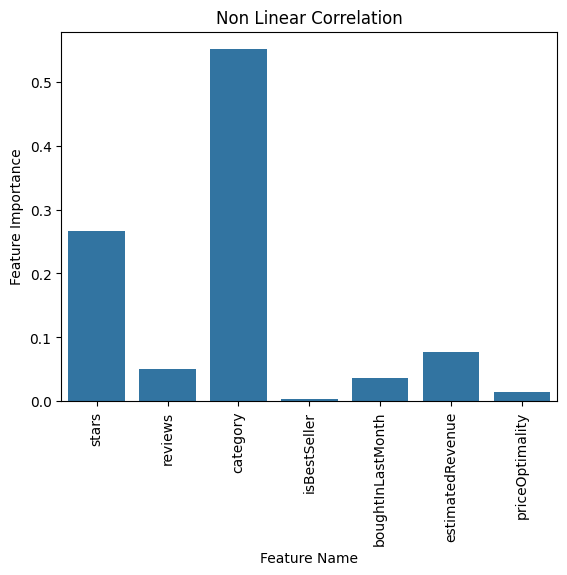

In [22]:
DTR= DecisionTreeRegressor(random_state= 42)
DTR.fit(sample_features, sample_target)

feature_importance= DTR.feature_importances_
sns.barplot(x= sample_features.columns,
            y= feature_importance)
plt.title('Non Linear Correlation')
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.xticks(rotation= 90);

## Data point distribution

### stars

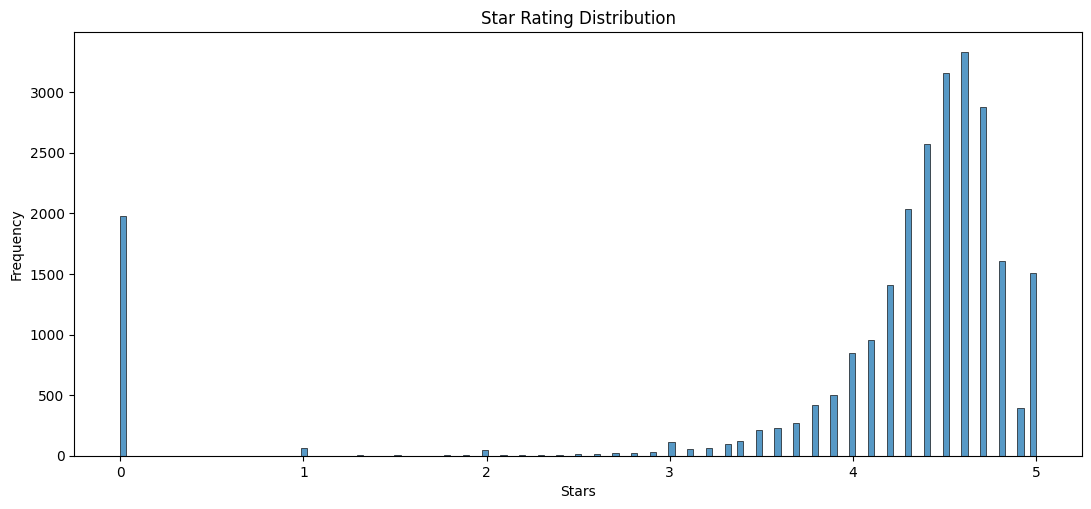

In [23]:
plt.figure(figsize= (13, 5.5))
sns.histplot(x= sample_dataframe.stars)
plt.title('Star Rating Distribution')
plt.ylabel('Frequency')
plt.xlabel('Stars');

## review

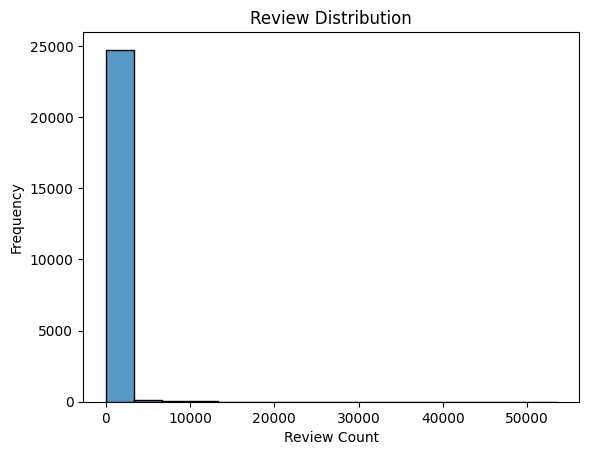

In [24]:
sns.histplot(x= sample_dataframe.reviews)
plt.title('Review Distribution')
plt.ylabel('Frequency')
plt.xlabel('Review Count');

## price optimality

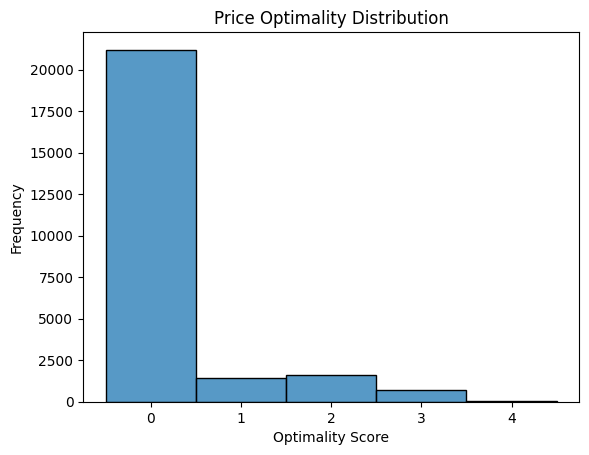

In [25]:
sns.histplot(x= sample_dataframe.priceOptimality)
plt.title('Price Optimality Distribution')
plt.ylabel('Frequency')
plt.xlabel('Optimality Score');

## stars vs. price

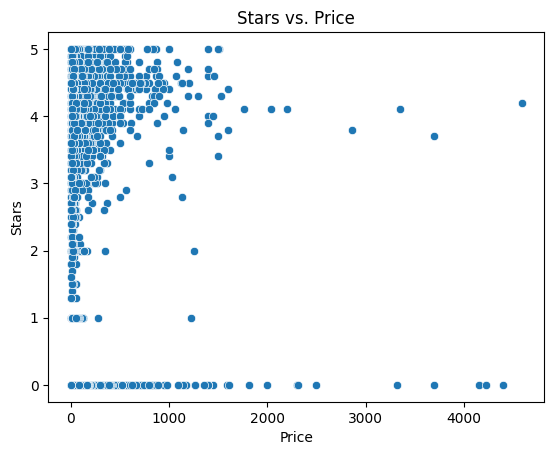

In [26]:
sns.scatterplot(x= 'price', y= 'stars', data= sample_dataframe)
plt.title('Stars vs. Price')
plt.ylabel('Stars')
plt.xlabel('Price');

# Yeo-Johnson Transformation

Splitting dataframe into features and target.

In [27]:
features, target= dataframe.drop('price', axis= 1), dataframe.price

As we have observed that majority of data is right-skewed, we have to apply Yeo-Johnson transformation to it in order to bring data closer to normal distribution

In [28]:
YJ= PowerTransformer(method= 'yeo-johnson', standardize= True)

transformed_features= YJ.fit_transform(features)
features= pd.DataFrame(data= transformed_features, columns= features.columns, index= features.index)

## Feature scaling

In [29]:
scaler= MinMaxScaler()

scaled_features= scaler.fit_transform(features)
features= pd.DataFrame(data= scaled_features, columns= features.columns, index= features.index)

In [30]:
dataframe= pd.concat([features, target], axis= 1)

# Visualization After Data Transformation

In [31]:
sample_dataframe= dataframe.sample(25_000, random_state= 42)

## Linear correlation

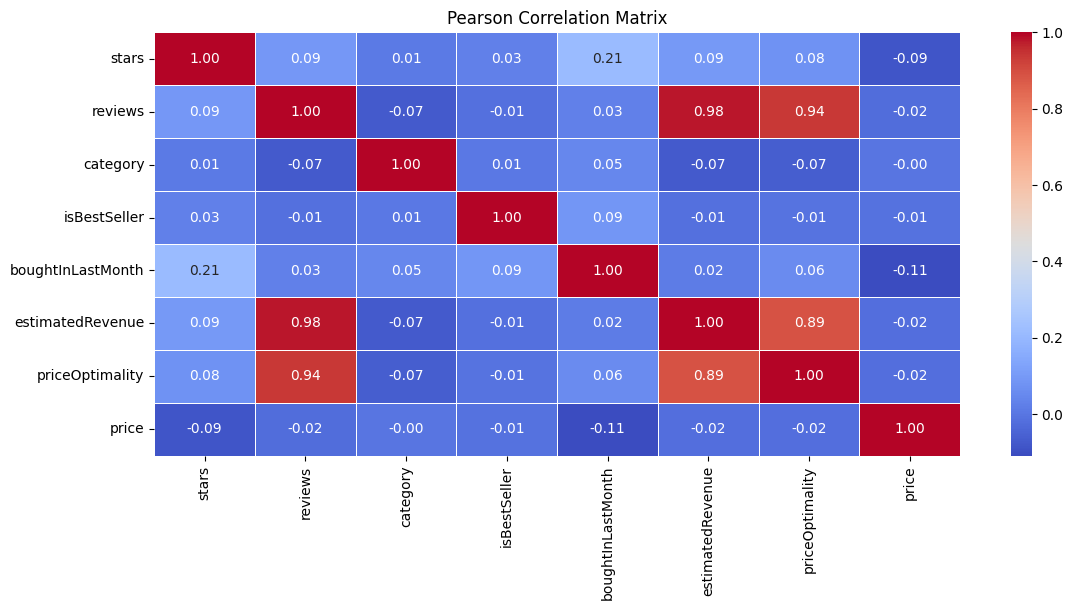

In [32]:
plt.figure(figsize= (13, 5.5))
sns.heatmap(sample_dataframe.corr(),
            annot= True,
            cmap= 'coolwarm',
            fmt= '.2f',
            linewidths= 0.5)
plt.title('Pearson Correlation Matrix');

## Non-linear correlation

In [33]:
sample_features= sample_dataframe.drop('price', axis= 1)
sample_target= sample_dataframe.price

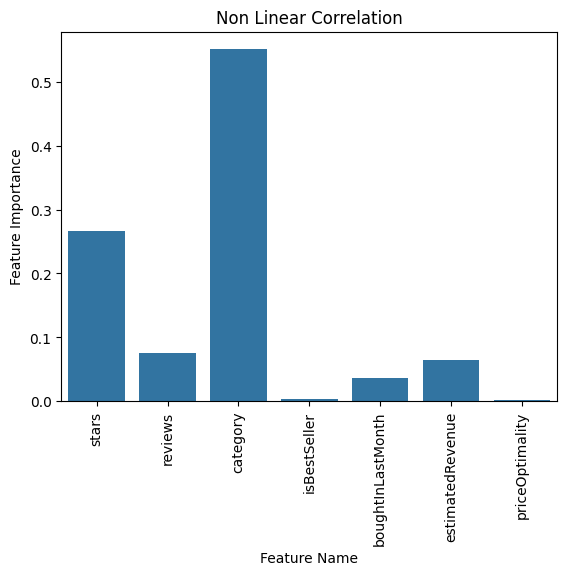

In [34]:
DTR= DecisionTreeRegressor(random_state= 42)
DTR.fit(sample_features, sample_target)

feature_importance= DTR.feature_importances_
sns.barplot(x= sample_features.columns,
            y= feature_importance)
plt.title('Non Linear Correlation')
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.xticks(rotation= 90);

## Dropping extraneous features from sample dataset see effects on multicollinearity.

In [35]:
sample_dataframe.drop(['reviews', 'estimatedRevenue'], axis= 1, inplace= True)

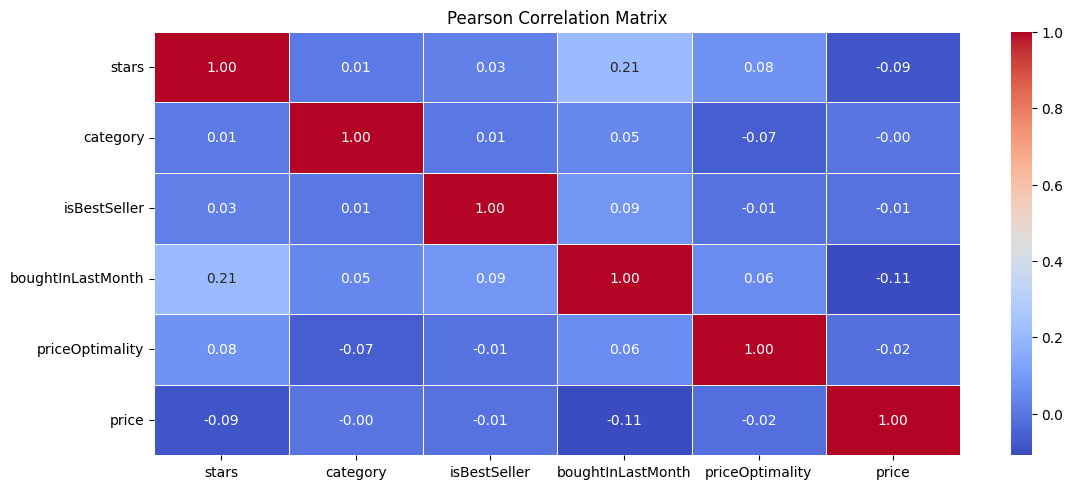

In [36]:
plt.figure(figsize= (13, 5.5))
sns.heatmap(sample_dataframe.corr(),
            annot= True,
            cmap= 'coolwarm',
            fmt= '.2f',
            linewidths= 0.5)
plt.title('Pearson Correlation Matrix');

In [37]:
sample_features= sample_dataframe.drop('price', axis= 1)
sample_target= sample_dataframe.price

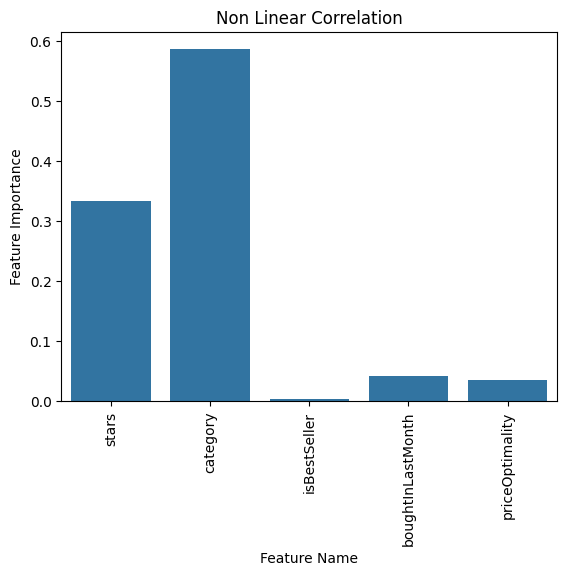

In [38]:
DTR= DecisionTreeRegressor(random_state= 42)
DTR.fit(sample_features, sample_target)

feature_importance= DTR.feature_importances_
sns.barplot(x= sample_features.columns,
            y= feature_importance)
plt.title('Non Linear Correlation')
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.xticks(rotation= 90);

Rejecting the idea of dropping the extraneous features as they hold importance in non linear relations.

# Data Splitting

In [39]:
train_features, test_features, train_target, test_target= train_test_split(features, target, test_size= 0.2, random_state= 42)

In [40]:
train_features.shape, train_target.shape, test_features.shape, test_target.shape

((1388331, 7), (1388331,), (347083, 7), (347083,))

# Data Storage

In [41]:
def pickle_file(dataframe, file_name, folder_name='notebook_artifacts'):
     # Ensure the folder name ends with a path separator
    dir_path = os.path.join(folder_name, '')
    # Create the folder if it doesn't exist
    os.makedirs(dir_path, exist_ok=True)
    # Create the full file path
    full_path = os.path.join(dir_path, file_name)  

    with open(full_path, 'wb') as f:
        pickle.dump(dataframe, f)

In [42]:
# Save the train features
pickle_file(train_features, 'train_features.pkl')

# Save the test features
pickle_file(test_features, 'test_features.pkl')

# Save the train target
pickle_file(train_target, 'train_target.pkl')

# Save the test target
pickle_file(test_target, 'test_target.pkl')